Device: cpu
Using INPUT_PATH: C:\Users\latha\Downloads\hagrid-master\hagrid-master\dataset\dataset.py
Input path not a file or folder; falling back to parent: 
Searching for dataset folders under: /content
Found dataset folder (deep search): /content/gestures/multi-hand-gesture-dataset-main
Using dataset folder: /content/gestures/multi-hand-gesture-dataset-main
Using ImageFolder + random split (80/20).
Classes: ['test', 'train']
Train samples: 637 | Val samples: 159
GestureCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0,

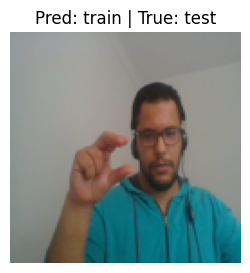

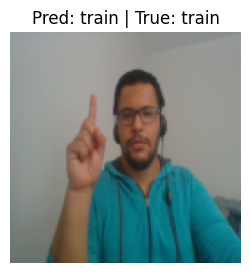

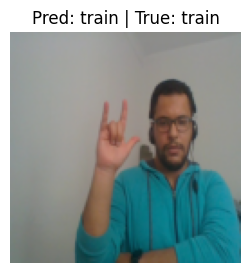

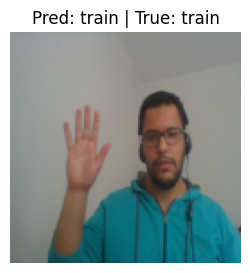

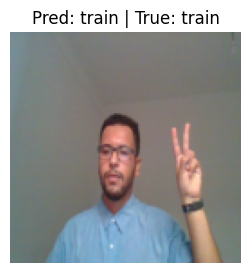

In [ ]:
"""
Complete script that:
- Runs dataset.py if you point to a .py (to create/download the images)
- Searches the repo for a folder with class subfolders containing images
- Loads dataset with ImageFolder (or train/val if present)
- Trains a small CNN and visualizes a few examples
"""

import os
import sys
import subprocess
import shutil
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Optional

# --------------------------
# USER: change this to your path (the path you gave)
# --------------------------
INPUT_PATH = r"C:\Users\latha\Downloads\hagrid-master\hagrid-master\dataset\dataset.py"
# --------------------------

# Basic config
batch_size = 16
img_size = 128
num_epochs = 3
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = min(4, (os.cpu_count() or 1))

print("Device:", device)
print("Using INPUT_PATH:", INPUT_PATH)

IMAGE_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

def run_dataset_script_if_needed(path: str) -> str:
    """
    If path is a .py file, run it (cwd = its folder).
    Return the folder to search for image folders.
    """
    if os.path.isfile(path) and path.lower().endswith(".py"):
        script_dir = os.path.dirname(path)
        print(f"Detected dataset script: {path}\nRunning it (this may download/extract data)...")
        try:
            # run with the same python interpreter
            subprocess.run([sys.executable, path], cwd=script_dir, check=True)
            print("dataset.py ran successfully (or exited with code 0).")
        except subprocess.CalledProcessError as e:
            print("Warning: running dataset.py returned non-zero exit status.", e)
            print("Continuing to search for image folders anyway...")
        return script_dir
    elif os.path.isdir(path):
        return path
    else:
        # If path doesn't exist, try parent assuming user provided a .py that may be wrong
        parent = os.path.dirname(path)
        print(f"Input path not a file or folder; falling back to parent: {parent}")
        return parent

def find_dataset_folder(root: str) -> Optional[str]:
    """
    Walk the root and attempt to locate a directory that contains class subfolders
    where at least one subfolder has image files.
    Returns the path to the dataset dir or None.
    """
    root = os.path.abspath(root)
    print("Searching for dataset folders under:", root)
    # First check immediate children (common case)
    try:
        for entry in os.scandir(root):
            if entry.is_dir():
                # Does this directory contain class-subfolders that contain images?
                subdirs = [d for d in os.scandir(entry.path) if d.is_dir()]
                if subdirs:
                    for d in subdirs:
                        try:
                            names = os.listdir(d.path)
                        except PermissionError:
                            names = []
                        if any(name.lower().endswith(IMAGE_EXTS) for name in names):
                            print("Found dataset folder:", entry.path)
                            return entry.path
    except FileNotFoundError:
        pass

    # Deep search (walk)
    for dirpath, dirnames, filenames in os.walk(root):
        # If directory has at least 2 subdirectories (likely class folders)
        if len(dirnames) >= 1:
            # Check if at least one subdir contains image files
            for d in dirnames:
                sub = os.path.join(dirpath, d)
                try:
                    files = os.listdir(sub)
                except PermissionError:
                    continue
                if any(fn.lower().endswith(IMAGE_EXTS) for fn in files):
                    # Found candidate: dirpath contains class subfolders
                    print("Found dataset folder (deep search):", dirpath)
                    return dirpath

    # If there is a train/val layout, detect that
    for candidate in ("train", "Train", "TRAIN"):
        cand_path = os.path.join(root, candidate)
        if os.path.isdir(cand_path):
            # check if train contains subfolders with images
            for entry in os.scandir(cand_path):
                if entry.is_dir():
                    if any(f.lower().endswith(IMAGE_EXTS) for f in os.listdir(entry.path)):
                        print("Found dataset folder (train/val layout):", root)
                        return root

    print("No dataset folder found under:", root)
    return None

# run dataset script if needed and find folder
root_to_search = run_dataset_script_if_needed(INPUT_PATH)
dataset_folder = find_dataset_folder(root_to_search)

# If not found, also check the same folder as dataset.py (maybe images live there)
if dataset_folder is None:
    alt = os.path.dirname(INPUT_PATH)
    if alt and alt != root_to_search:
        dataset_folder = find_dataset_folder(alt)

if dataset_folder is None:
    # Try a fallback: if there are any images directly under root_to_search, create "unknown" class folder
    files = []
    try:
        files = os.listdir(root_to_search)
    except Exception:
        pass
    if any(fn.lower().endswith(IMAGE_EXTS) for fn in files):
        fallback = os.path.join(root_to_search, "images_for_training")
        os.makedirs(fallback, exist_ok=True)
        # move images into fallback (only if they are not already inside subfolders)
        for fn in files:
            if fn.lower().endswith(IMAGE_EXTS):
                src = os.path.join(root_to_search, fn)
                dst = os.path.join(fallback, fn)
                if not os.path.exists(dst):
                    shutil.move(src, dst)
        print("Moved top-level images into:", fallback)
        dataset_folder = root_to_search

if dataset_folder is None:
    raise FileNotFoundError(f"Could not locate dataset class folders automatically. Look in: {root_to_search}\n"
                            "Make sure folder contains class subfolders each with images (e.g. dataset/class1/*.jpg).")

# At this point dataset_folder should contain class subfolders (or be train/val layout)
print("Using dataset folder:", dataset_folder)

# -------------------------
# Build torchvision datasets
# -------------------------
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# If dataset uses train/val folders already:
train_dir = os.path.join(dataset_folder, "train")
val_dir   = os.path.join(dataset_folder, "val")
if os.path.isdir(train_dir) and os.path.isdir(val_dir):
    print("Detected separate train/val directories.")
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
else:
    # Single folder with class subfolders - use ImageFolder + random split
    print("Using ImageFolder + random split (80/20).")
    full_dataset = datasets.ImageFolder(dataset_folder, transform=train_transform)
    total = len(full_dataset)
    if total == 0:
        raise RuntimeError("ImageFolder found 0 images. Check dataset folder contents.")
    val_size = int(0.2 * total)
    train_size = total - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    # ensure val uses val_transform
    val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=(device.type=="cuda"))
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=(device.type=="cuda"))

# classes
if hasattr(train_dataset, "classes"):
    class_names = train_dataset.classes
else:
    # random_split wraps dataset; get classes from underlying dataset
    class_names = train_dataset.dataset.classes
print("Classes:", class_names)
print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

# -------------------------
# Model (uses adaptive pooling so it doesn't depend on img_size exactly)
# -------------------------
class GestureCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        # make size independent using adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

num_classes = len(class_names)
model = GestureCNN(num_classes).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# -------------------------
# Training loop
# -------------------------
def train_model(epochs=num_epochs):
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        # validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_sum = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss_sum / max(1, val_total)
        val_acc = 100.0 * val_correct / max(1, val_total)

        print(f"Epoch {epoch}/{epochs} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% "
              f"| Val loss: {val_loss:.4f} | Val acc: {val_acc:.2f}%")

    # Save model
    save_path = os.path.join(os.getcwd(), "gesture_cnn.pth")
    torch.save(model.state_dict(), save_path)
    print("Saved model to:", save_path)

train_model()

# -------------------------
# Visualization of a few validation images
# -------------------------
def imshow(img_tensor, title=None):
    img = img_tensor.cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img = img * 0.5 + 0.5  # unnormalize
    plt.figure(figsize=(3,3))
    plt.imshow(np.clip(img, 0, 1))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# get some batch from val_loader
try:
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    for i in range(min(5, images.size(0))):
        pred_label = class_names[preds[i].cpu().item()]
        true_label = class_names[labels[i].cpu().item()]
        imshow(images[i].cpu(), f"Pred: {pred_label} | True: {true_label}")
except Exception as e:
    print("Could not visualize validation images:", e)
